<a href="https://colab.research.google.com/github/zuobinxiong/CS789/blob/main/Evasion_Attack_CNN_instructor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attacking a CNN

The CNN is vunerable to adversarial examples as ![adv example](https://www.tensorflow.org/tutorials/generative/images/adversarial_example.png)

In this exercise we will train a CNN to distinguish between instances of handwritten `0` and instances of handwritten `1`. We will be using `PyTorch` to do this.  

Once we have a trained classifier, we will create adversarial examples from scratch using `ART`

This is adopted from https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/examples/get_started_pytorch.py

In [ ]:
# some configurations for jupyter notebook
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 57.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt


The MNIST dataset contains data for all of the digits.

We need to normalize the data. Here, we use the API from `ART`.

Load the actual data. It will load the data as numpy array.

In [ ]:
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist

In [ ]:
# Step 1: Load the MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Step 1a: Swap axes to PyTorch's NCHW format

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

In [ ]:
print(type(x_train))
print(x_train.shape, x_test.shape, y_train.shape)

<class 'numpy.ndarray'>
(60000, 1, 28, 28) (10000, 1, 28, 28) (60000, 10)


We are using a very simple CNN. This network can be used to distinguish between all 10 classes with very high accuracy.

In [ ]:
# define the classifier
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1)
        self.conv_2 = nn.Conv2d(in_channels=4, out_channels=10, kernel_size=5, stride=1)
        self.fc_1 = nn.Linear(in_features=4 * 4 * 10, out_features=100)
        self.fc_2 = nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 10)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x


Then, we initialize a model and train with the cross-entropy loss.

To simplify the training code, we use the wrapper `PyTorchClassifier` from `ART` to train the model.

In [ ]:
# Step 2: Create the model

model = Net()

# Step 2a: Define the loss function and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 3: Create the ART classifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

# Step 4: Train the ART classifier

classifier.fit(x_train, y_train, batch_size=64, nb_epochs=10)

# Step 5: Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 97.91%


In [ ]:
# the device(cpu/gpu) of the model

device = next(model.parameters()).device
device

device(type='cuda', index=0)

Let's get to the actual attack. First, we pick a sample that we want to perturb. After that we will be implementing our own FGSM attack.

The attack is fairly simple. It consists of the following steps:

1.   Compute the loss of the original sample
2.   Calculate the gradient of the loss w.r.t the input
3.   Take the sign of the gradient and add a fraction episilon to the input, namely $x + \epsilon sign(\nabla_x J(x, y))$

Epsilon controlls the strenght of the pertubation.

First, we select a sample to visualize it and output the model's predictions.

(1, 28, 28)


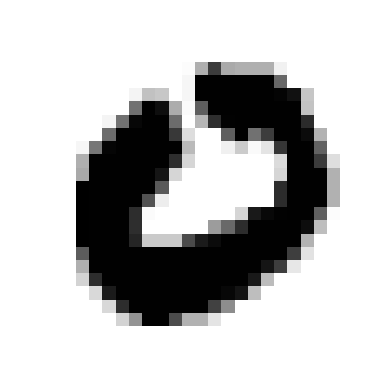

output for the test samples:
 [[ 13.671443   -11.777933    -7.687038   -21.041943    -5.429765
   -6.2753296   -0.38672453  -5.0125756   -6.6972246   -5.7071023 ]]
class prediction for the test samples:
 tensor([[1.0000e+00, 8.8609e-12, 5.2982e-10, 8.3978e-16, 5.0635e-09, 2.1738e-09,
         7.8454e-07, 7.6848e-09, 1.4256e-09, 3.8371e-09]], device='cuda:0')
predicted as [0]


In [ ]:

#chose a sample to pertubate
sample_ind = 25 # chosen by totaly random dice roll

# picking a test sample
sample = x_test[ sample_ind, : ]

print( sample.shape )

# plot the first instance in the traning set
plt.imshow( sample.reshape( 28, 28 ), cmap="gray_r" )
plt.axis( 'off' )
plt.show( )

t_sample = torch.FloatTensor(sample.reshape( (1, sample.shape[ 0 ], sample.shape[ 1 ], sample.shape[ 2 ]) ) ).to(device)
pred_prob = F.softmax(model( t_sample ), dim=1)

logits = classifier.predict( sample.reshape( (1, sample.shape[ 0 ], sample.shape[ 1 ], sample.shape[ 2 ]) ) )

print( 'output for the test samples:\n', logits )
print( 'class prediction for the test samples:\n', pred_prob.detach() )
print( 'predicted as', np.argmax( logits , axis=1) )

Since `ART` loads data as numpy array, we create a variable as PyTorch Tensor for convenience.

In [ ]:
t_sample = torch.FloatTensor(sample.reshape( (1, sample.shape[ 0 ], sample.shape[ 1 ], sample.shape[ 2 ]) ) ).to(device)
one_hot_y = torch.LongTensor( y_test[ sample_ind, : ].reshape( ( 1, -1 ) ) ).to(device)
t_y = torch.argmax(one_hot_y, dim=1)

Construct adversarial examples from scratch.

It's caused by the mechanism of PyTorch.

By default, only model's parameters will compute/require gradients.

Now, we need to let the input data require gradients.

our adversarial example
torch.Size([1, 1, 28, 28])
logits for our sample: 	
 [[  6.1596036  -10.54993      0.34596282 -14.467785    -4.449729
   -5.318031     6.3282347   -7.0117745   -8.034576    -5.3612666 ]]
class prediction for our sample: 	
 tensor([[4.5731e-01, 2.5313e-08, 1.3658e-03, 5.0332e-10, 1.1288e-05, 4.7373e-06,
         5.4131e-01, 8.7086e-07, 3.1315e-07, 4.5369e-06]], device='cuda:0')
predicted as [6]


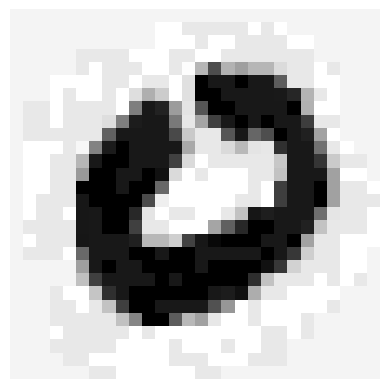

In [ ]:
# constructing adversarial examples
######################
# fill in the blanks #
######################

eps = 0.05# allowed maximum modification

# Set the data require gradients

t_sample.requires_grad = True

# compute logits

logits = model(t_sample)

# compute the loss of our original sample

loss = nn.CrossEntropyLoss()(logits, t_y)

# get the gradient wrt to the input.

grads = torch.autograd.grad(loss, [t_sample])[0]

# calculate the pertubation

perturbation = torch.sign(grads)

# apply pertubation

x_adv = t_sample + perturbation * eps

# now that we have the adversarial examples
# get the prediction result and print the adversarial example


print( 'our adversarial example' )
print( x_adv.shape )
print( 'logits for our sample: \t\n', classifier.predict( x_adv.cpu().detach().numpy() ) )
print( 'class prediction for our sample: \t\n', F.softmax( model( x_adv ), dim=1 ).detach()  )
print( 'predicted as', np.argmax( classifier.predict( x_adv.cpu().detach().numpy() ) , axis=1) )
plt.imshow( x_adv.cpu().detach().numpy().reshape( 28, 28 ), cmap="gray_r" )
plt.axis( 'off' )
plt.show( )


The FGSM is one of the most simple attacks.
As we can see, results are not very convincing since the perturbation is perceptible.
We can improve on it by making it iterative.

Using the code from above, create an iterative version of FGSM that calculates a new perturbation for ever iteration and stops once it achieve misclassifaction.



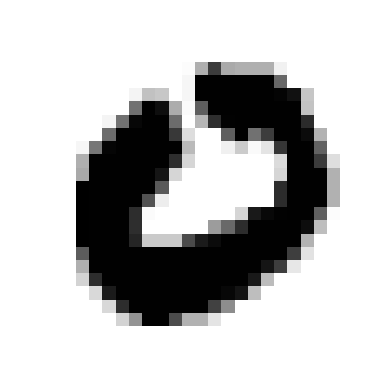

In [ ]:
plt.imshow( t_sample.cpu().detach().numpy().reshape( 28, 28 ), cmap="gray_r" )
plt.axis( 'off' )
plt.show( )

our adversarial example
torch.Size([1, 1, 28, 28])
logits for our sample: 	
 [[  0.9449905  -4.557856   -2.9043484 -13.162658   -3.3962893  -5.0581985
    6.0764914  -8.176232   -1.8672246  -4.1838756]]
class prediction for our sample: 	
 tensor([[5.8693e-03, 2.3918e-05, 1.2498e-04, 4.3824e-09, 7.6418e-05, 1.4502e-05,
         9.9350e-01, 6.4164e-07, 3.5258e-04, 3.4766e-05]], device='cuda:0')
predicted as [6]


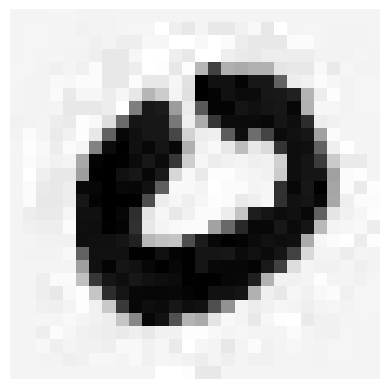

In [ ]:
epsilon = 0.005
iterations = 10

x_adv = t_sample.detach().clone()
x_adv.requires_grad = True

for i in range(iterations):
    # your code here

    # compute logits

    logits = model(x_adv)

    # compute the loss of our original sample

    loss = nn.CrossEntropyLoss()(logits, t_y)

    # get the gradient wrt to the input.

    grads = torch.autograd.grad(loss, [x_adv])[0]

    # calculate the pertubation

    perturbation = torch.sign(grads)

    # apply pertubation

    x_adv.data += perturbation.detach() * epsilon

print( 'our adversarial example' )
print( x_adv.shape )
print( 'logits for our sample: \t\n', classifier.predict( x_adv.cpu().detach().numpy() ) )
print( 'class prediction for our sample: \t\n', F.softmax( model( x_adv ), dim=1 ).detach()  )
print( 'predicted as', np.argmax( classifier.predict( x_adv.cpu().detach().numpy() ) , axis=1) )
plt.imshow( x_adv.cpu().detach().numpy().reshape( 28, 28 ), cmap="gray_r" )
plt.axis( 'off' )
plt.show( )

Let's use `ART` library to do the actual attack.

We will also use the FGSM attack to generate an adversarial example.

In [ ]:
# Evaluate
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on clean test examples: {}%".format(accuracy * 100))

from art.attacks.evasion import FastGradientMethod
attack = FastGradientMethod(estimator=classifier, eps=0.2)
x_test_adv = attack.generate(x=x_test)

# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Accuracy on clean test examples: 97.91%
Accuracy on adversarial test examples: 48.52%


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

logits for our sample: 	
 [[-11.306394     1.8971353    2.1593668   -0.76262766 -20.211578
   -8.560522    -6.92595    -15.361308    20.980938   -13.58745   ]]
predicted as [8]


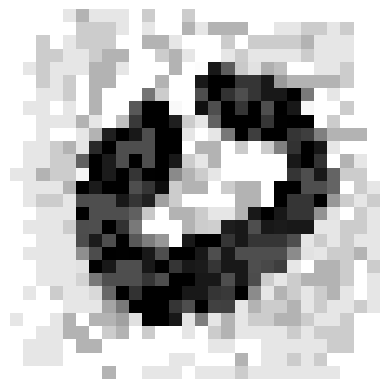

In [ ]:
# Visualize one example
x_test_adv = attack.generate(x=x_test[sample_ind:sample_ind+1, ])
print( 'logits for our sample: \t\n', classifier.predict( x_test_adv ) )
# print( 'class prediction for our sample: \t\n', F.softmax( model( x_test_adv ), dim=1 ).detach()  )
print( 'predicted as', np.argmax( classifier.predict( x_test_adv ) , axis=1) )

plt.imshow( x_test_adv.reshape( 28, 28 ), cmap="gray_r" )
plt.axis( 'off' )
plt.show( )

You can see that it's much simpler than we write it from scratch.

You can check it from https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/examples/get_started_pytorch.py

We have seen that FGSM does not do a great job of producing adversarial examples when work with 0 and 1. Update the code above work on all 10 digits and try for a number of 0 instance what class they get transformed into in an untargeted attack.
Alternativley pick a pair of numbers that you think are closer to each orther and the FGSM attack should work better with.


`ART` provides more attacks than the once introduced above. Try any other attacks from the official documents.

You can find more information on the attacks here: https://github.com/Trusted-AI/adversarial-robustness-toolbox/wiki/ART-Attacks and https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#projected-gradient-descent-pgd

Accuracy on clean test examples: 97.91%


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 2.9899999999999998%


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

logits for our sample: 	
 [[-11.306394     1.8971353    2.1593668   -0.76262766 -20.211578
   -8.560522    -6.92595    -15.361308    20.980938   -13.58745   ]]
predicted as [8]


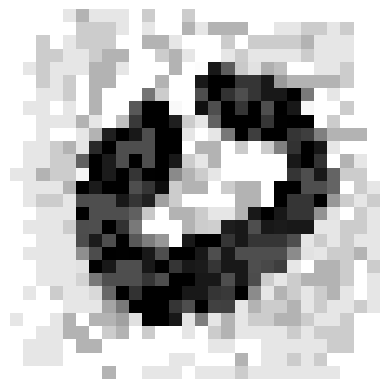

In [ ]:
# your code here

# Evaluate
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on clean test examples: {}%".format(accuracy * 100))

from art.attacks.evasion import ProjectedGradientDescent
attack = ProjectedGradientDescent(estimator=classifier, max_iter=20)
x_test_adv = attack.generate(x=x_test)

# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

# Visualize one example
x_test_adv = attack.generate(x=x_test[sample_ind:sample_ind+1, ])
print( 'logits for our sample: \t\n', classifier.predict( x_test_adv ) )
# print( 'class prediction for our sample: \t\n', F.softmax( model( x_test_adv ), dim=1 ).detach()  )
print( 'predicted as', np.argmax( classifier.predict( x_test_adv ) , axis=1) )

plt.imshow( x_test_adv.reshape( 28, 28 ), cmap="gray_r" )
plt.axis( 'off' )
plt.show( )